In [2]:

import os
import requests
import sys
import gzip

import datetime
import time




import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [3]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

In [4]:
reg = 3
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)

In [5]:
#Analyse de la consommation en tant que série temporelle 
sub_df = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
valeurs = sub_df['Total énergie soutirée (Wh)'] / sub_df['Nb points soutirage']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d = {'date': date, 'consommation': valeurs}


serie = pd.DataFrame(d)
serie.set_index('date', inplace=True)
start_time = serie.index.min()
serie.index = ((serie.index - start_time).total_seconds() / 1800).astype(int)



#Analyse de la température moyenne en tant que série temporelle 
valeurs_T = sub_df['T_moyenne']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d_T = {'date': date, 'T_moyenne': valeurs_T}


serie_T = pd.DataFrame(d_T)
serie_T.set_index('date', inplace=True)
start_time = serie_T.index.min()
serie_T.index = ((serie_T.index - start_time).total_seconds() / 1800).astype(int)

D:\Temp\ipykernel_26308\133494381.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
D:\Temp\ipykernel_26308\133494381.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))


In [6]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

forceast_long = 28*48
test_long = 48
serie_log_np = serie #['consommation']

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]
test = serie_annee.iloc[-test_long:]


In [ ]:

test = serie_annee.iloc[-test_long:]
sarima_conso = auto_arima(train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=1, m=48, max_P =2, max_Q =0,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)



sarima_conso.summary()

In [8]:
from statsmodels.tsa.statespace import sarimax

sarima_conso = SARIMAX(train['consommation'],order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      

results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()

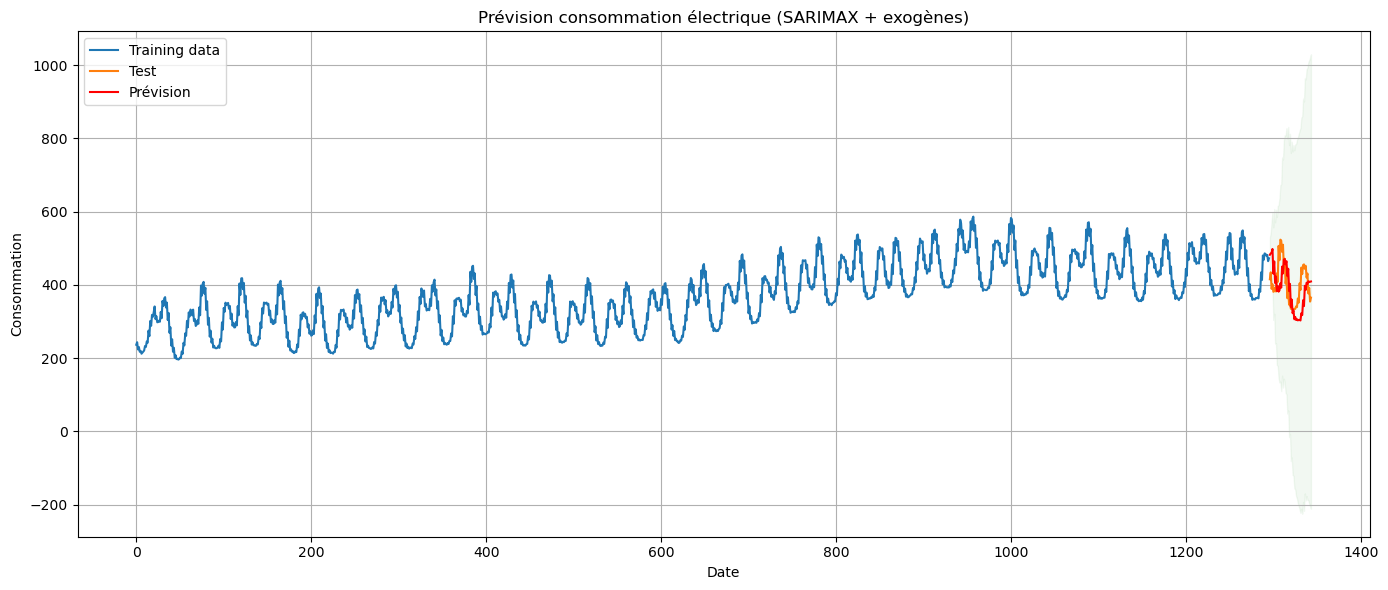

In [9]:
test = serie_annee.iloc[-test_long:]
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()


plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='g', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

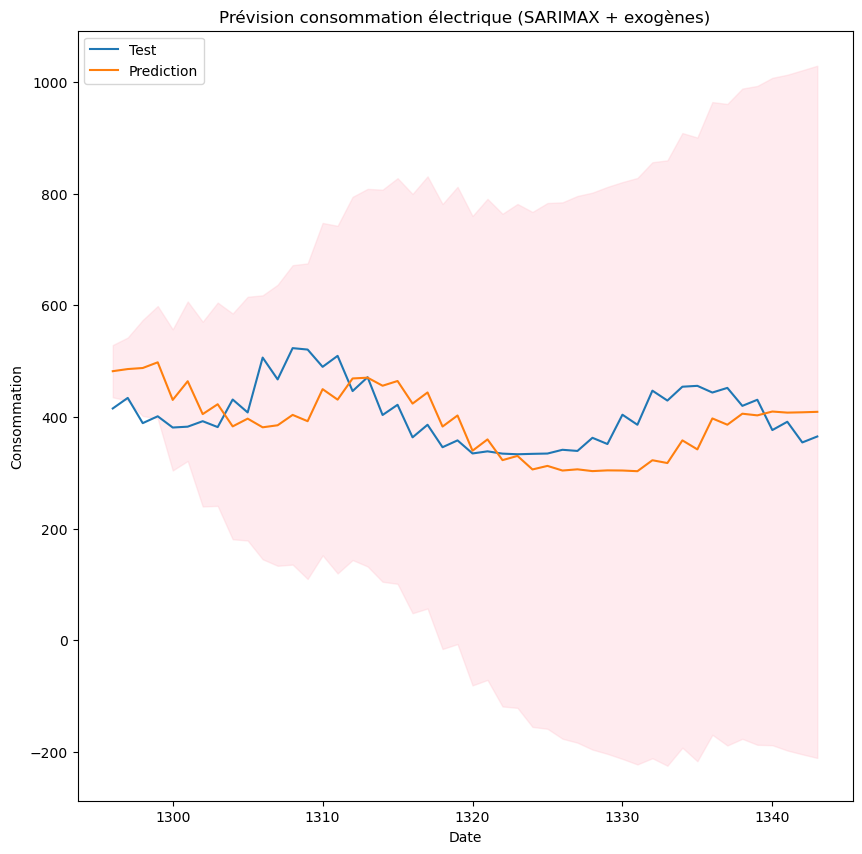

MAPE: 13.23%


In [10]:
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label ="Prediction")

plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


mape = mean_absolute_percentage_error(test, prediction)
print(f"MAPE: {mape:.2%}")

In [11]:
# Décomposition 

from statsmodels.tsa.seasonal import seasonal_decompose 
# Premier niveau de décomosition
decomposition_1 = seasonal_decompose(serie, period=48,  model='multiplicative', extrapolate_trend='freq') 
trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
resid_1 = decomposition_1.resid
# Deuxième niveau de décomosition

decomposition_2= seasonal_decompose(trend_1, period=48*7, model='multiplicative', extrapolate_trend='freq') #
trend_2 = decomposition_2.trend
seasonal_2 = decomposition_2.seasonal
resid_2 = decomposition_2.resid


# A prédire 
# Longueur séries 
forceast_long = 28*48
test_long = 48

X_1 =  seasonal_1.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,48)
X_2 =  trend_1.iloc[0: forceast_long]  #  RL par rapport à la 1/température  
X_3 =  resid_1.iloc[0: forceast_long]  # par SARIMAX (5,1,2)(1,1,0,14) 
#X_4 =  resid_1 .iloc[0: forceast_long]* resid_2.iloc[0: forceast_long]



# Décomposition T
decomposition_T = seasonal_decompose(serie_T, period=48,   extrapolate_trend='freq') #

#plt.plot(trend_1.iloc[0: forceast_long],'r')
#plt.plot(X_2,'b')
#plt.plot(X_3,'g')
#plt.plot(X_4,'k')

In [41]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prediction de X_1

train_X_1 = X_1.iloc[0:(len(X_1)-test_long)]
test_X_1 =  X_1.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(train_X_1.values,order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_1 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_1 = results_X_1.get_forecast(steps=len(test_X_1))
print("moyenne prediction ...")
prediction_X_1 = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()





modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1381: RuntimeWarning: overflow encountered in scalar power
  constrained[start] = unconstrained[start]**2
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction...
moyenne prediction ...
IC...


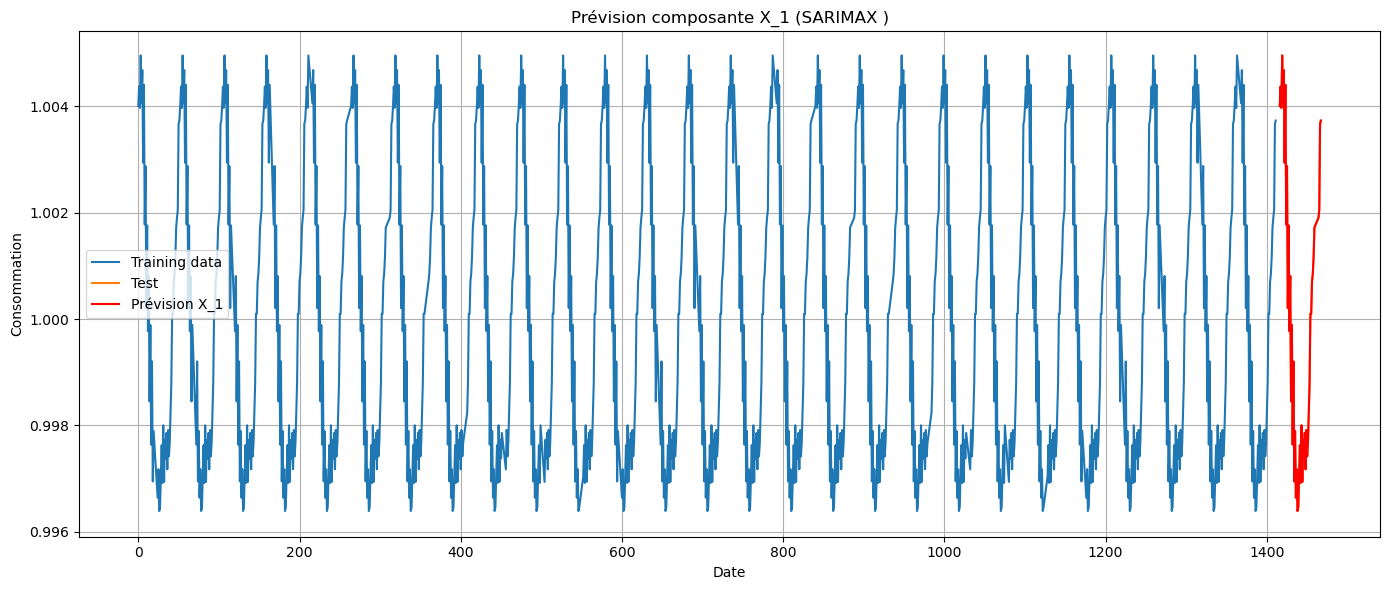

MAPE: 0.00%


In [42]:
# Visualisation pour X_1 

prediction_X_1 = pd.Series(prediction_X_1, index = test_X_1.index)

plt.figure(figsize=(14, 6))
plt.plot(train_X_1, label = 'Training data')
plt.plot(test_X_1, label ='Test')
plt.plot(prediction_X_1, label='Prévision X_1', color='red')
plt.fill_between(prediction_X_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_X_1, label ='Test')
plt.plot(prediction_X_1, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_X_1, prediction_X_1)
print(f"MAPE: {mape:.2%}")

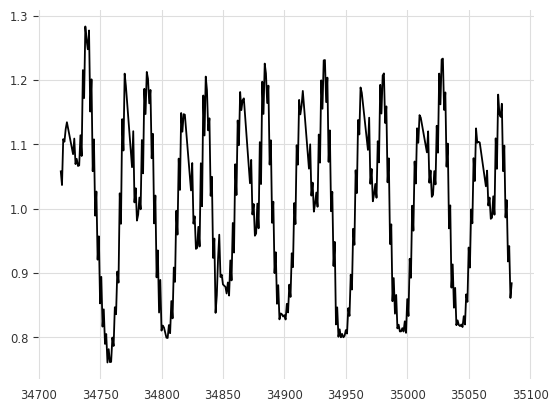

In [ ]:
decomposition_r = seasonal_decompose(resid_1, period=48,  model='multiplicative', extrapolate_trend='freq') 
trend_r = decomposition_r.trend
seasonal_r = decomposition_r.seasonal
resid_r = decomposition_r.resid

plt.plot(resid_1[-7*48:])
plt.show()



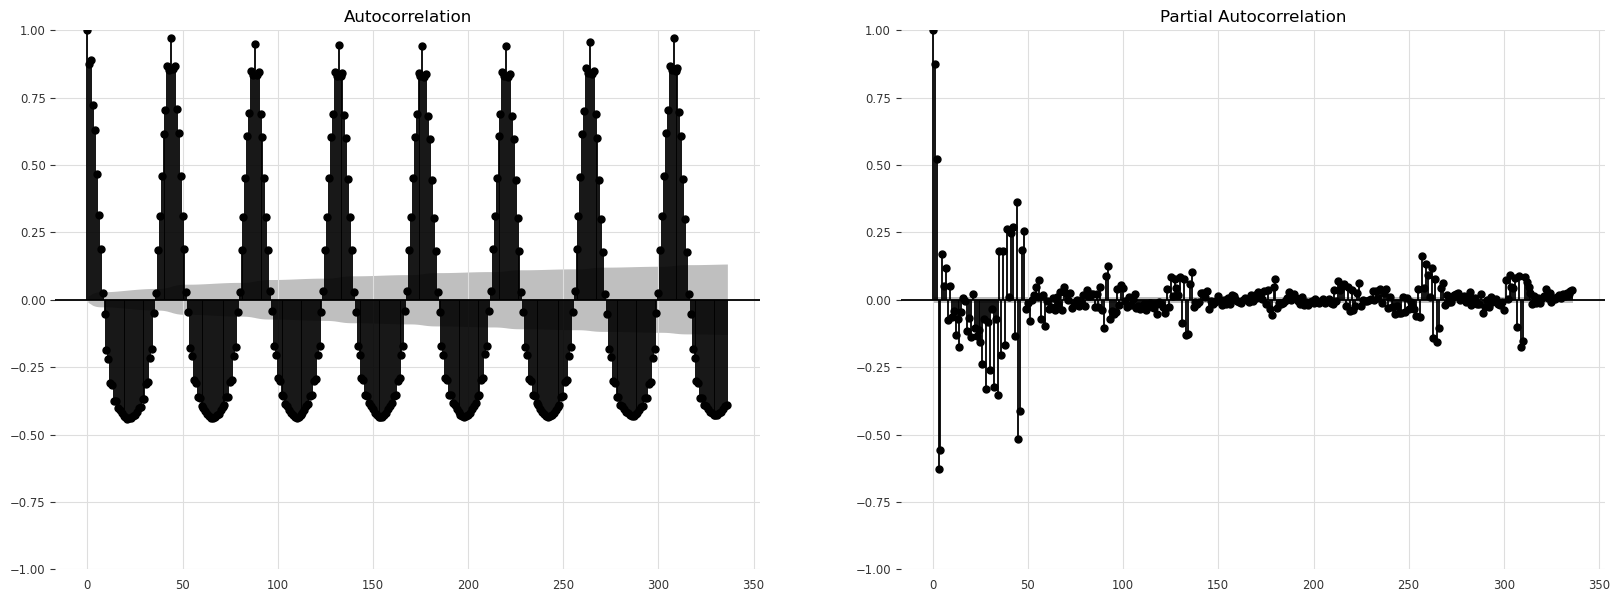

In [223]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(resid_1, lags = 48*7, ax=ax1)
plot_pacf(resid_1, lags = 48*7, ax=ax2)
plt.show()

In [298]:

train_resid_1 = trend_1.iloc[0:(len(trend_1)-test_long)]
test_resid_1 =  trend_1.iloc[-test_long:]
sarima_conso = auto_arima(train_resid_1,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=5, max_q=5,max_P =5, max_Q =5,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5776.486, Time=7.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88285.063, Time=3.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13036.069, Time=1.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=88284.565, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=29.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8115.223, Time=12.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=33310.412, Time=7.54 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15290.251, Time=20.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-15676.977, Time=34.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10250.898, Time=13.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-17070.790, Time=47.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=34.88 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-17376.733, Time=50.38 sec
 ARIMA(5,1,1)(0,0,0)[0] i

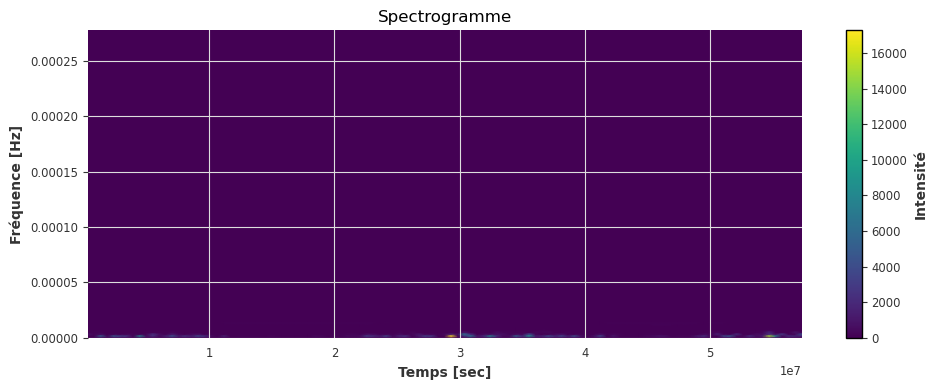

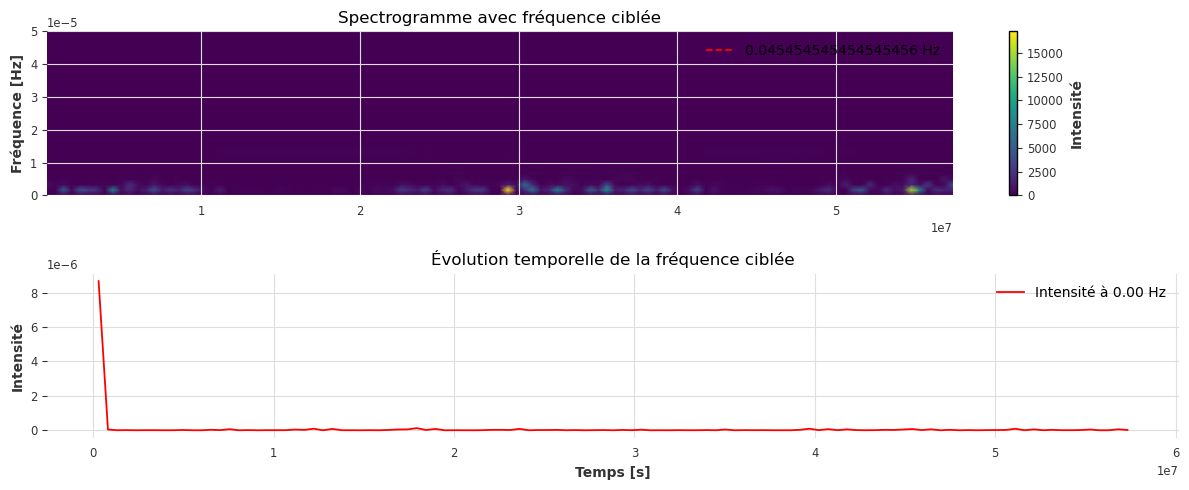

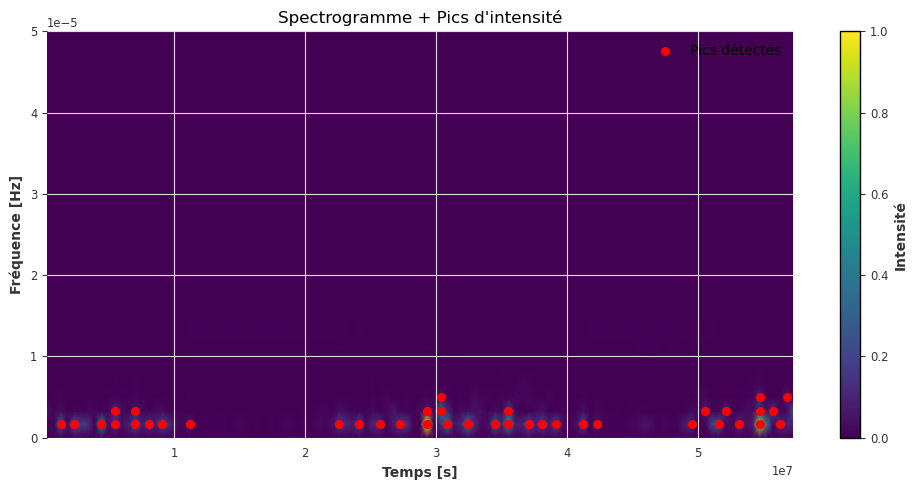

In [313]:
# Analyse spectrales
from scipy.signal import spectrogram
from scipy.signal import spectrogram, find_peaks
#serie_sp = (serie.values.reshape(1,len(serie_log))[0])

#serie_sp = sub_df['Total énergie soutirée (Wh)']
def plot_spectrogramme(f, t_spec, Sxx):
    # Affichage
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.ylabel('Fréquence [Hz]')
    plt.xlabel('Temps [sec]')
    #plt.ylim([0, 0.1])
    plt.title('Spectrogramme')
    plt.colorbar(label='Intensité')
    plt.tight_layout()
    plt.show()



def marquage_raie_spectre( f, t_spec, Sxx, target_freq):
    freq_idx = np.argmin(np.abs(f - target_freq))
    #  Extraire son intensité dans le temps
    intensity_at_freq = Sxx[freq_idx, :]
    # Afficher le spectrogramme + la courbe à 5 Hz
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.axhline(f[freq_idx], color='r', linestyle='--', label=f'{target_freq} Hz')
    plt.colorbar(label='Intensité')
    plt.ylabel('Fréquence [Hz]')
    plt.ylim([0, 0.00005])
    plt.title('Spectrogramme avec fréquence ciblée')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(t_spec, intensity_at_freq, label=f"Intensité à {f[freq_idx]:.2f} Hz", color='r')
    plt.xlabel('Temps [s]')
    plt.ylabel('Intensité')
   
    plt.title('Évolution temporelle de la fréquence ciblée')
    plt.legend()

    plt.tight_layout()
    plt.show()





def identification_peak(f, t_spec, Sxx,threshold ):
    peak_coords = []
    for freq_idx, power in enumerate(Sxx):
        peaks, properties = find_peaks(power, height=threshold)
        for p in peaks:
                peak_coords.append((t_spec[p], f[freq_idx], power[p]))
    # Résultat sous forme de tableau
    peak_coords = np.array(peak_coords)
    # Affichage du spectrogramme + pics
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.scatter(peak_coords[:, 0], peak_coords[:, 1], c='red', s=30, label='Pics détectés')
    plt.xlabel('Temps [s]')
    plt.ylabel('Fréquence [Hz]')
    plt.colorbar(label='Intensité')
    plt.title('Spectrogramme + Pics d\'intensité')
    plt.ylim([0, 0.00005])
    plt.legend()
    plt.tight_layout()
    plt.show()
    return peak_coords







# Analyse spectrale 
serie_sp =np.log(trend_1.dropna())

f, t_spec, Sxx = spectrogram(serie_sp,  nperseg = 7*48, noverlap = 48, fs=1/1800)

plot_spectrogramme(f, t_spec, Sxx)

marquage_raie_spectre( f, t_spec, Sxx, target_freq = 1/22)
picks  = identification_peak(f, t_spec, Sxx,threshold = 0.1e4)




In [312]:
spectrum_mean = np.mean(Sxx, axis=1)

# Fréquences avec pics
from scipy.signal import find_peaks

peaks, _ = find_peaks(spectrum_mean, height=np.max(spectrum_mean)*0.05)  # seuil à ajuster
frequencies_raies = f[peaks]
print("Fréquences des raies spectrales (j) :", 1/(1800*frequencies_raies))

Fréquences des raies spectrales (j) : [42.         22.4        14.60869565]


WARNING - (py.warnings._showwarnmsg) - c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['disp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)



modèle...
entrainement...


WARNING - (py.warnings._showwarnmsg) - c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

WARNING - (py.warnings._showwarnmsg) - c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(

WARNING - (py.warnings._showwarnmsg) - c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



prediction...
moyenne prediction ...
IC...


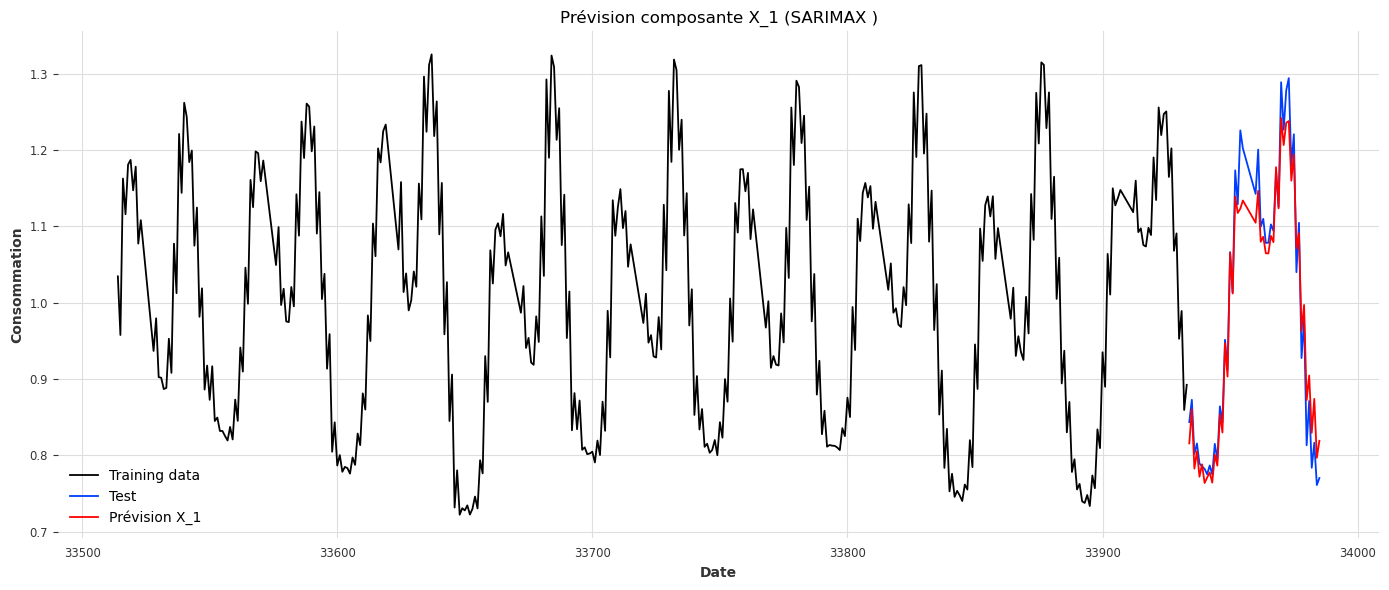

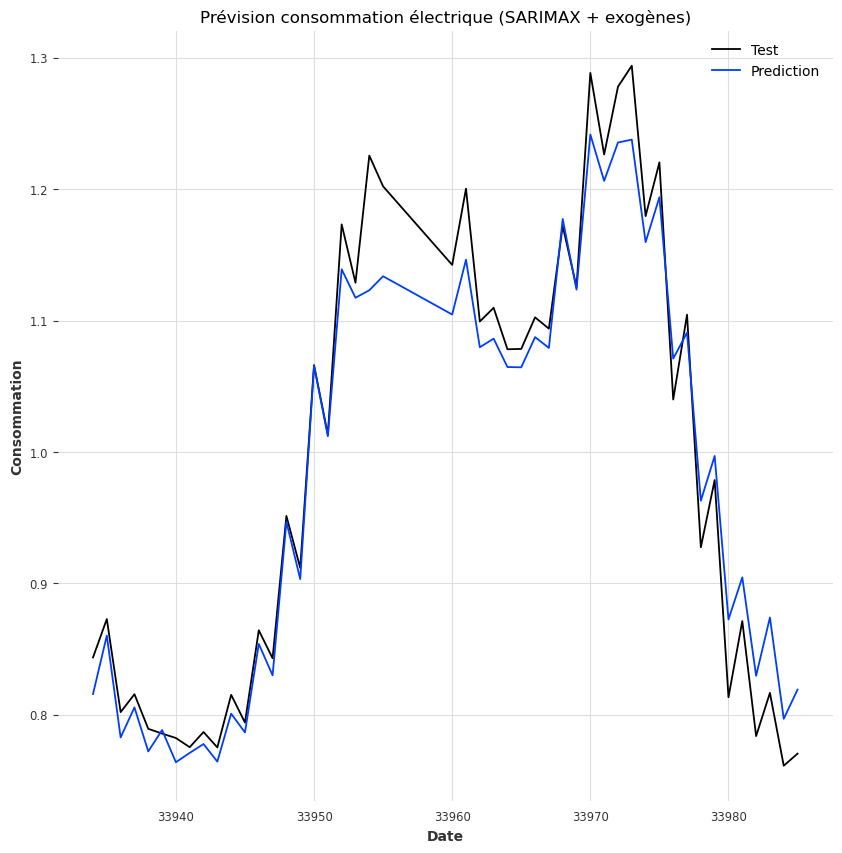

MAPE: 2.51%


In [316]:
# Prediction de resid_1


train_resid_1 = resid_1.iloc[len(resid_1) - 30*test_long:(len(resid_1)-22*test_long)] 
test_resid_1 =  resid_1.iloc[len(resid_1)-22*test_long:len(resid_1)-21*test_long]



print("modèle...")

sarima_conso = SARIMAX(train_resid_1,
                      order=(5,1,2),
                      seasonal_order=(1,1,1,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False,
                       disp=False)
                      
print("entrainement...")
results_resid_1 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_resid_1 = results_resid_1.get_forecast(steps=len(test_resid_1))
print("moyenne prediction ...")
prediction_resid_1 = forecast_resid_1.predicted_mean
print("IC...")
#conf_int = forecast_resid_1.conf_int()



# Affichage 
# Visualisation pour X_1 

prediction_resid_1 = pd.Series(prediction_resid_1.values, index = test_resid_1.index)

plt.figure(figsize=(14, 6))
plt.plot(train_resid_1, label = 'Training data')
plt.plot(test_resid_1, label ='Test')
plt.plot(prediction_resid_1, label='Prévision X_1', color='red')
#plt.fill_between(prediction_resid_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_resid_1, label ='Test')
plt.plot(prediction_resid_1, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_resid_1, prediction_resid_1)
print(f"MAPE: {mape:.2%}")



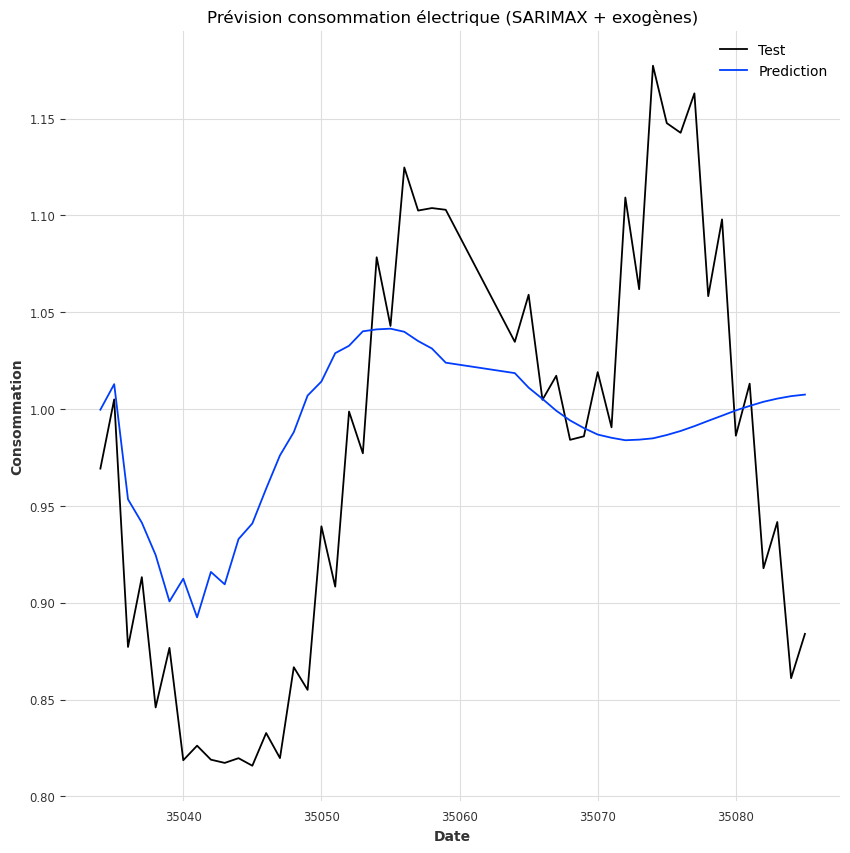

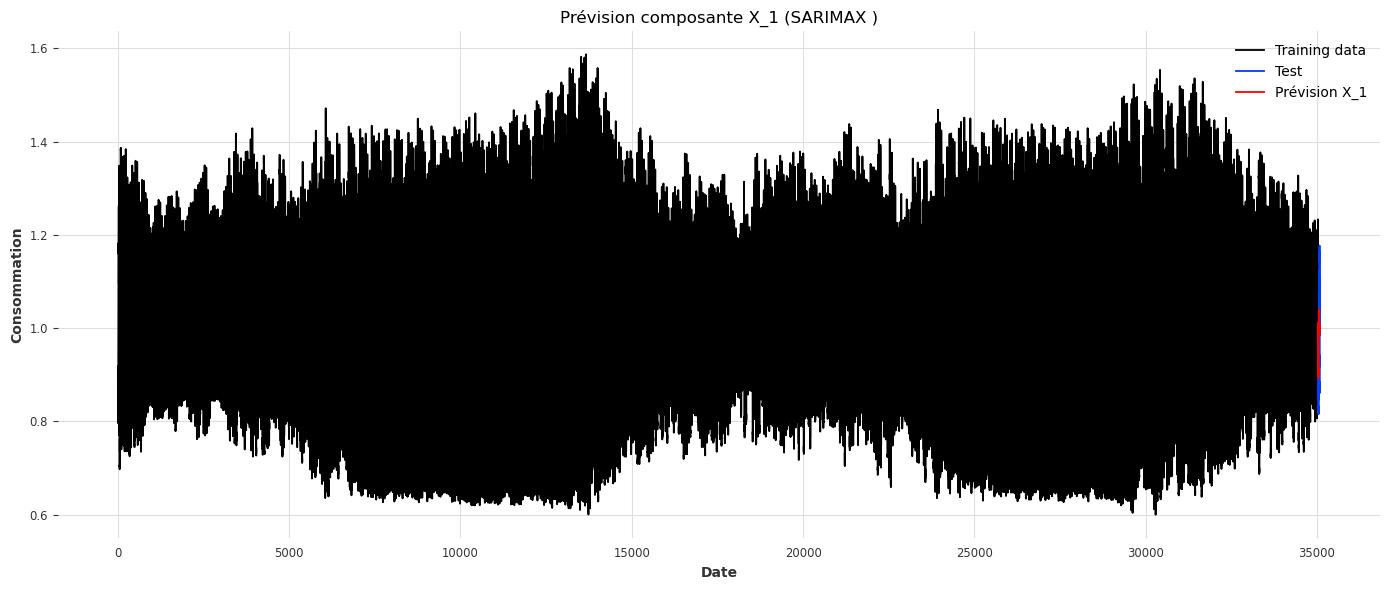

MAPE: 7.97%


In [275]:
prediction_resid_1 = pd.Series(prediction_resid_1.values, index = test_resid_1.index)

plt.figure(figsize=(14, 6))
plt.plot(train_resid_1, label = 'Training data')
plt.plot(test_resid_1, label ='Test')
plt.plot(prediction_resid_1, label='Prévision X_1', color='red')
#plt.fill_between(prediction_resid_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_resid_1, label ='Test')
plt.plot(prediction_resid_1, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_resid_1, prediction_resid_1)
print(f"MAPE: {mape:.2%}")

In [ ]:

# Prediction de X_2

train_X_2 = X_2.iloc[0:(len(X_2)-test_long)]
test_X_2 =  X_2.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(train_X_2.values,order=(1,1,0),
                      seasonal_order=(1,1,0,112),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_2 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_2 = results_X_2.get_forecast(steps=len(test_X_2))
print("moyenne prediction ...")
prediction_X_2 = forecast_X_2.predicted_mean
print("IC...")
conf_int = forecast_X_2.conf_int()

"""
print("modèle...")
estimator_X_2 = TBATS(seasonal_periods=(48*7,48))
model_X_2 = estimator_X_2.fit(train_X_2)# Forecast 365 days ahead
forecast_X_2 = model_X_2.forecast(steps=test_long)
"""

modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction...
moyenne prediction ...
IC...


'\nprint("modèle...")\nestimator_X_2 = TBATS(seasonal_periods=(48*7,48))\nmodel_X_2 = estimator_X_2.fit(train_X_2)# Forecast 365 days ahead\nforecast_X_2 = model_X_2.forecast(steps=test_long)\n'

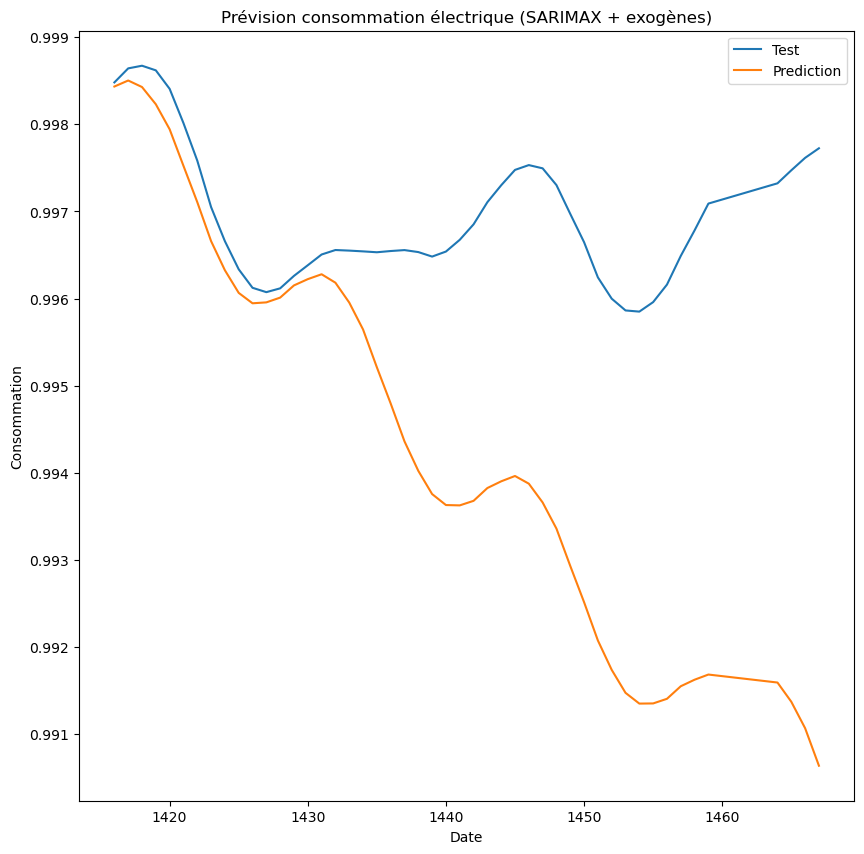

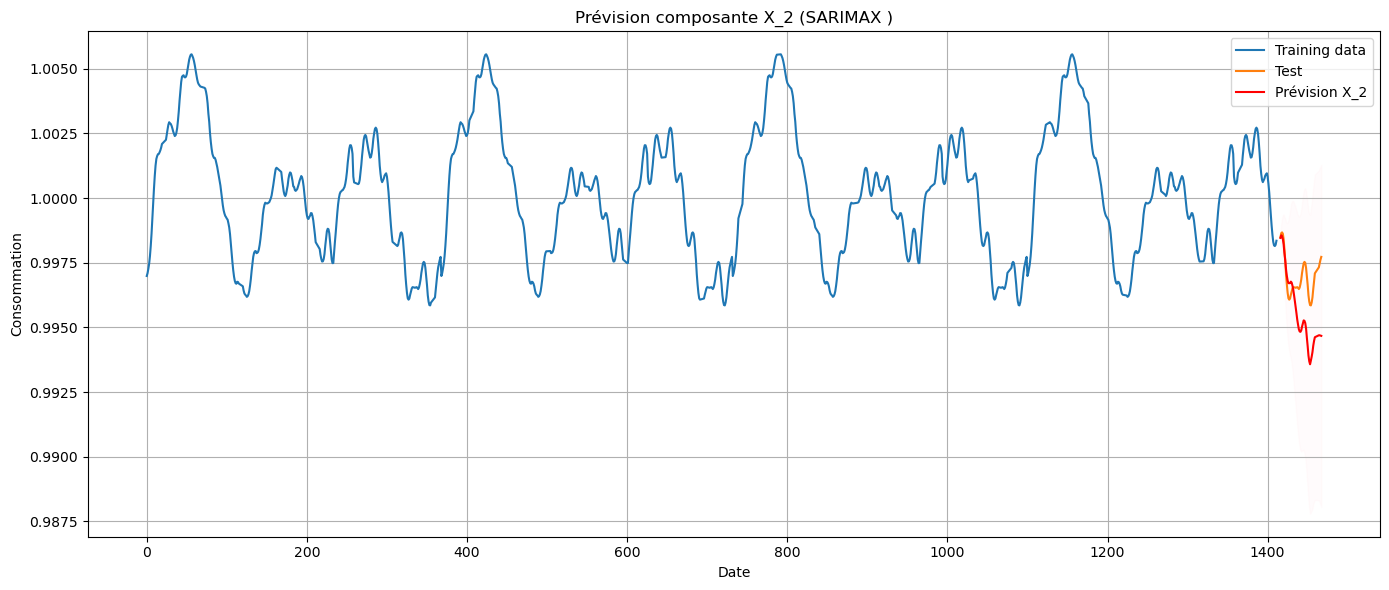

MAPE: 0.14%


In [55]:
# Visualisation pour X_2

prediction_X_2 = pd.Series(prediction_X_2, index = test_X_2.index)

plt.figure(figsize=(14, 6))
plt.plot(train_X_2, label = 'Training data')
plt.plot(test_X_2, label ='Test')
plt.plot(prediction_X_2, label='Prévision X_2', color='red')
plt.fill_between(prediction_X_2.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prévision composante X_2 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test_X_2, label ='Test')
plt.plot(prediction_X_2, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test_X_2, prediction_X_2)
print(f"MAPE: {mape:.2%}")

In [ ]:

forceast_long = 28*48
test_long = 48

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]

test = serie_annee.iloc[-test_long:]


sarima_conso = SARIMAX(train,order=(2,1,0),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      

results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()



plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prévision', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

In [ ]:
from tbats import TBATS, BATS


In [ ]:
# Fit the model
estimator = TBATS(seasonal_periods=(42,48*7, 365*48))
model = estimator.fit(train)# Forecast 365 days ahead
y_forecast = model.forecast(steps=48)

In [ ]:
serie_pred = pd.Series(y_forecast, index=test.index)

plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(serie_pred, label='Prévision', color='red')
#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.05)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(serie_pred, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

mape = mean_absolute_percentage_error(test, serie_pred)
print(f"MAPE: {mape:.2%}")

In [122]:

# Un autre modèle
from neuralprophet import NeuralProphet


df_neualprophet = sub_df[['Total énergie soutirée (Wh)', 'T_moyenne', 'U_moyenne', 'FF_moyenne', 'Nb points soutirage']]

date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
df_neualprophet['date'] = date
# Renommage pour respecter les noms attendus par NeuralProphet
df_neualprophet = df_neualprophet.rename(columns={
    "date": "ds",
    "Total énergie soutirée (Wh)": "y",
    "Nb points soutirage": "Nb"
})
df_neualprophet.drop_duplicates(inplace=True)
# Vérifie que les colonnes sont bien présentes
print(df_neualprophet.head())
# Création du modèle avec multi-saisonnalité
model = NeuralProphet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    #n_lags=48,             # 24 heures (si données toutes les 30 min)
    n_forecasts=48,        # prédire les prochaines 24 heures
)


# Ajouter les variables exogènes
model.add_lagged_regressor("T_moyenne")
model.add_lagged_regressor("U_moyenne")
model.add_lagged_regressor("FF_moyenne")
model.add_lagged_regressor("Nb")
# Entraînement du modèle
print("entrainement...")
metrics = model.fit(df_neualprophet, freq="30min")


# Étendre les données pour faire des prédictions futures
future = model.make_future_dataframe(df_neualprophet, periods=48)

# Faire les prédictions
print("prediction...")
forecast = model.predict(future)

# Voir les prédictions
forecast[['ds', 'y', 'yhat1']].tail(10)

model.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - D:\Temp\ipykernel_1260\707008402.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))

WARNING - (py.warnings._showwarnmsg) - D:\Temp\ipykernel_1260\707008402.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neualprophet['date'] = date

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there 

                  y  T_moyenne  U_moyenne  FF_moyenne       Nb  \
1157688  22612159.0  13.320408  63.878788    5.500000  95596.0   
1157689  23283679.0  13.320408  63.878788    5.500000  95596.0   
1157690  21384147.0  13.213265  65.212121    5.275000  95596.0   
1157691  22030006.0  13.213265  65.212121    5.275000  95596.0   
1157692  20791561.0  12.879592  67.242424    5.314286  95596.0   

                         ds  
1157688 2023-01-01 00:00:00  
1157689 2023-01-01 00:30:00  
1157690 2023-01-01 01:00:00  
1157691 2023-01-01 01:30:00  
1157692 2023-01-01 02:00:00  
entrainement...


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 40
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (251) is too small than the required number                     for the learning rate finder (262). The results might not be optimal.
Missing logger folder: d:\MesDocuments\Formation\DataScientist_PSL\Projet\Scripts\lightning_logs


Finding best initial lr:   0%|          | 0/262 [00:00<?, ?it/s]

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL neuralprophet.configure.ConfigSeasonality was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ConfigSeasonality])` or the `torch.serialization.safe_globals([ConfigSeasonality])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
from prophet import Prophet

# Préparation du DataFrame
df = sub_df.copy()

df["y"] = trend_1.values


# Construction du timestamp 'ds'
df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))

# Renommer la cible
df = df.rename(columns={
    #"Total énergie soutirée (Wh)": "y",
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Nb points soutirage": "Nb"
})

# Garder uniquement les colonnes utiles
df = df[['ds', 'y', 'T', 'U', 'FF', 'Nb']].dropna().drop_duplicates()


# séparation test & entrainement 
train_df = df.iloc[:-48]
test_df = df.iloc[-48:]
# Création du modèle Prophet
model = Prophet(
    #daily_seasonality=True,
    #weekly_seasonality=True,
    #yearly_seasonality=True
)

# Ajouter les variables exogènes (regressors)
for reg in ['T', 'U', 'FF', 'Nb']:
    model.add_regressor(reg)

# Entraînement sur le train
model.fit(train_df)

# Créer le futur avec les variables exogènes du test
future = test_df[['ds', 'T', 'U', 'FF', 'Nb']].copy()

# Prédiction
forecast = model.predict(future)



# Comparaison des vrais y vs yhat
y_true = test_df['y'].values
y_pred = forecast['yhat'].values


WARNING - (py.warnings._showwarnmsg) - D:\Temp\ipykernel_1260\3402870035.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))

14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:33 - cmdstanpy - INFO - Chain [1] done processing


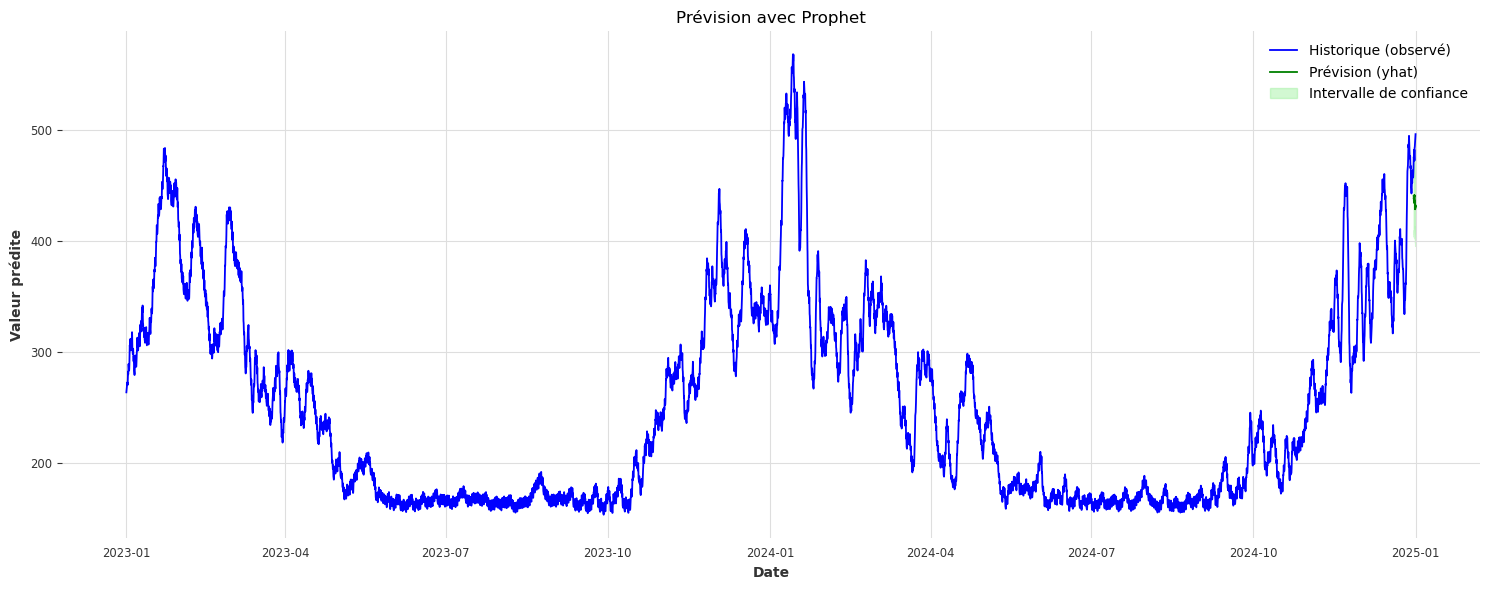

In [318]:
# Affichage avec historique + prédictions
plt.figure(figsize=(15, 6))

# 1. 🔵 Série historique (données d’entraînement)
plt.plot(df['ds'], df['y'], label='Historique (observé)', color='blue')

# 2. 🟢 Prédictions (yhat de Prophet)
plt.plot(forecast['ds'], forecast['yhat'], label='Prévision (yhat)', color='green')

# 3. (Optionnel) Intervalle de confiance
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='lightgreen', alpha=0.4, label='Intervalle de confiance')

plt.xlabel('Date')
plt.ylabel('Valeur prédite')
plt.title('Prévision avec Prophet')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

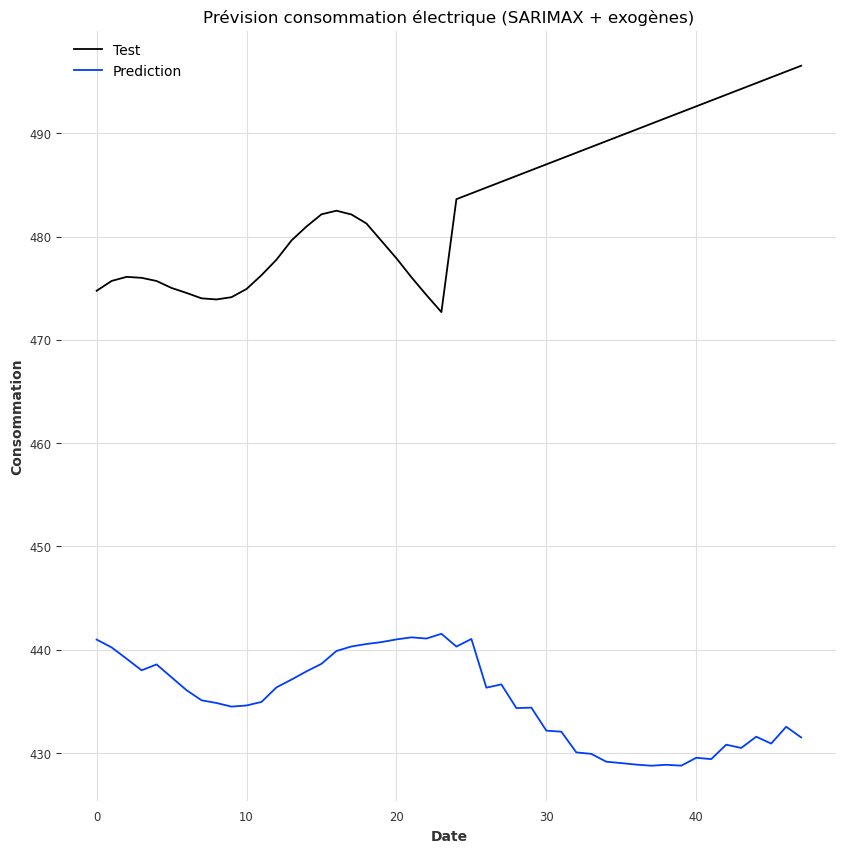

In [319]:
# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(y_true, label ='Test')
plt.plot(y_pred, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prévision consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


In [320]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# 🧮 Métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

✅ MAE  = 48.37
✅ RMSE = 49.62
✅ MAPE = 9.97%
